In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from Crypto.Util.number import inverse
def gcd(a, b):
    if b == 0:
        return a
    else:
        return gcd(b, a%b)

# Theory

- Elliptic curves mod N: https://www.youtube.com/watch?v=4oCfeV_qylw&list=PLKXdxQAT3tCssgaWOy5vKXAR4WTPpRVYK&index=76&ab_channel=JeffSuzuki
- Fast powering algorithm: https://www.youtube.com/watch?v=T6gOx_-hTKE&list=PLKXdxQAT3tCssgaWOy5vKXAR4WTPpRVYK&index=77&ab_channel=JeffSuzuki

Let $p > 3 \ $Then let $ E: \ y^2 = x^3 + ax + b $ where $ a,b \ \in \  \mathbb{F}_p$ and $4a^3 + 27b^2 \neq 0$ => The curve does not have double root

## The elliptic curve group

Let $E(\mathbb{F}_p)$ be a curve over a finite field. A point (x,y) with $x, y \in \mathbb{F}_p$ that satisfies the equation is a **point on the curve** ($\mathbb{F}_{p^e}$ with $e>1$  is an extension of the base field and can also be used as a group for coordinates)

**The number of points on the curve**:
- https://en.wikipedia.org/wiki/Hasse%27s_theorem_on_elliptic_curves

Let $E$ be an elliptic curve over $\mathbb{F}_p$ and let  
$t = p + 1 − |E(\mathbb{F}_p)|$  
with $|t| ≤ 2\sqrt{p}$. $t$ is named the trace of Frobenius

# Code

In [8]:
def modular_sqrt(a, p): #tonelli shanks algorithm for square roots

    def legendre_symbol(a, p):
        """ Compute the Legendre symbol a|p using
            Euler's criterion. p is a prime, a is
            relatively prime to p (if p divides
            a, then a|p = 0)
            Returns 1 if a has a square root modulo
            p, -1 otherwise.
        """
        ls = pow(a, (p - 1) // 2, p)
        return -1 if ls == p - 1 else ls

    """ Find a quadratic residue (mod p) of 'a'. p
        must be an odd prime.
        Solve the congruence of the form:
            x^2 = a (mod p)
        And returns x. Note that p - x is also a root.
        0 is returned is no square root exists for
        these a and p.
        The Tonelli-Shanks algorithm is used (except
        for some simple cases in which the solution
        is known from an identity). This algorithm
        runs in polynomial time (unless the
        generalized Riemann hypothesis is false).
    """
    # Simple cases
    #
    if legendre_symbol(a, p) != 1:
        return 0
    elif a == 0:
        return 0
    elif p == 2:
        return p
    elif p % 4 == 3:
        return pow(a, (p + 1) // 4, p)

    # Partition p-1 to s * 2^e for an odd s (i.e.
    # reduce all the powers of 2 from p-1)
    #
    s = p - 1
    e = 0
    while s % 2 == 0:
        s //= 2
        e += 1

    # Find some 'n' with a legendre symbol n|p = -1.
    # Shouldn't take long.
    #
    n = 2
    while legendre_symbol(n, p) != -1:
        n += 1

    # Here be dragons!
    # Read the paper "Square roots from 1; 24, 51,
    # 10 to Dan Shanks" by Ezra Brown for more
    # information
    #

    # x is a guess of the square root that gets better
    # with each iteration.
    # b is the "fudge factor" - by how much we're off
    # with the guess. The invariant x^2 = ab (mod p)
    # is maintained throughout the loop.
    # g is used for successive powers of n to update
    # both a and b
    # r is the exponent - decreases with each update
    #
    x = pow(a, (s + 1) // 2, p)
    b = pow(a, s, p)
    g = pow(n, s, p)
    r = e

    while True:
        t = b
        m = 0
        for m in range(r):
            if t == 1:
                break
            t = pow(t, 2, p)

        if m == 0:
            return x

        gs = pow(g, 2 ** (r - m - 1), p)
        g = (gs * gs) % p
        x = (x * gs) % p
        b = (b * g) % p
        r = m

In [19]:
class EllipticCurveFp(object):
    def __init__(self, a, b, p):
        '''
        input a and b for the y^2 = x^3 + ax + b form
       
        '''
        self.a = a % p
        self.b = b % p 
        self.p = p
        
        self.discriminant = -16*(4 * pow(a, 3, p) + 27 * pow(b, 2, p)) % p
        if not self.is_smooth():
            raise Exception("the curve %s is not smooth!" % self)
        
        
    def is_smooth(self):
        return self.discriminant!=0
    
    
    def test_point(self, x, y):
        return pow(y, 2, self.p) == ((pow(x, 3, self.p) + self.a * x + self.b ) % self.p)
    
    
    def get_all_points(self):
        '''gets points WITHOUT the ideal. The ideal is coded as (np.inf, np.inf)'''
        all_points = list()
        all_points.append(PointFp(self, 0, 1, 0))
        for x in range(self.p):
            y_sq =  (pow(x, 3, self.p) + self.a * x + self.b ) % self.p
            y = modular_sqrt(y_sq, self.p)
            if  y != 0: #0 is when no root exists
                all_points.append(PointFp(self, x, y))
                all_points.append(PointFp(self, x, self.p-y))
        return all_points
        
        
    def __str__(self):
        return ('y^2 = x^3 + %Gx + %G mod %G' %(self.a, self.b, self.p))
    
    
    def __eq__(self, other):
        return (self.a, self.b, self.p) == (other.a, other.b, other.p)

In [20]:
class PointFp(object):
    ''' 
    a point on a curve
    for any point that is not the ideal z = 1
    we consider the ideal to have x = 0, y = 1, z = 0
    '''
    def __init__(self, curve, x, y, z = 1):
        if z == 1:
            self.curve = curve #the elliptic curve containing the point
            self.x, self.y = x % curve.p, y % curve.p
            self.z = z
            if not curve.test_point(self.x, self.y):
                raise Exception("The point %s is not on the given curve %s" %(self, curve))
        else:
            self.x, self.y, self.z = x, y, z
            self.curve = curve


    def __neg__(self):
        return PointFp(self.curve, self.x, -self.y % self.curve.p)
    
    
    def __eq__(self, other):
        if(self.curve == other.curve and self.x == other.x and self.y == other.y):
            return True
        else:
            return False
        
        
    def __add__(self, other):
        if(self.z!=1):
            return other
        elif(other.z!=1):
            return self
        elif(self.x == other.x and self.y == -other.y % self.curve.p):
            return PointFp(self.curve, 0, 1, 0)
        else:
            #doubling
            if self == other:
                num = (3*pow(self.x, 2) + self.curve.a)
                denom = (2*self.y)
                gcd_temp = gcd(denom, self.curve.p)
                if gcd_temp !=1:
                    return PointFp(self.curve, 0, 0, denom)
                else:
                    lam = num * inverse(denom, self.curve.p)
            else :
                num = (self.y - other.y)
                denom = (self.x - other.x)
                gcd_temp = gcd(denom, self.curve.p)
                if gcd_temp !=1:
                    return PointFp(self.curve, 0, 0, denom)
                else:
                    lam =  num * inverse(denom, self.curve.p)
            x_3 = (lam**2 - self.x - other.x) % self.curve.p
            y_3 = (lam*(self.x - x_3) - self.y) % self.curve.p
            return PointFp(self.curve, x_3, y_3)
    
    
    def __sub__(self, other):
        return self + - other
            
        
    def __str__(self):
        return ("(%s, %s, %s)" % (self.x, self.y, self.z))
    
    
    def __mul__(self, n):
        n = n % self.curve.p
        if not isinstance(n, int):
            raise Exception ("can't scale if n isnt integer")
        else:
            if n == 0:
                return PointFp(self.curve, 0, 1, 0)
            else:
                Q = self
                R = self if n & 1 == 1 else PointFp(self.curve, 0, 1, 0)
                i = 2
                while i<=n:
                    Q = Q + Q
                    if n & i == i:
                        R = Q + R
                    i = i << 1 
        return R 
    
    
    def __rmul__(self, n):
        return self * n 
    
    
    def __hash__(self):
        return hash(str(self))


In [21]:
curve = EllipticCurveFp(3, 8, 13)

In [22]:
set_13  = curve.get_all_points()

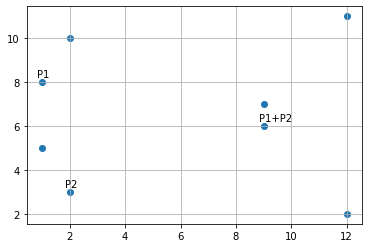

In [25]:
x = [elem.x for elem in set_13 if elem.z == 1]
y = [elem.y for elem in set_13 if elem.z == 1]
P1 = set_13[1]
P2 = set_13[3]
P3 = P1 + P2
P3_temp = -P3
plt.grid()
plt.scatter(x, y)

#plt.plot(*P1, 'ro')
plt.annotate('P1', xy=(P1.x, P1.y), xytext=(-5, 5), textcoords='offset points')
#plt.plot(*P2, 'ro')
plt.annotate('P2', xy=(P2.x, P2.y), xytext=(-5, 5), textcoords='offset points')
#plt.plot(*P3, 'ro')
plt.annotate('P1+P2', xy=(P3.x, P3.y), xytext=(-5, 5), textcoords='offset points')
plt.show()



check this notebook for plots, i'm way too lazy to do this  
basically the line that goes through P1 and P2 wraps arround until it hits a point. Reflect that point to get P1 + P2
https://github.com/fangpenlin/elliptic-curve-explained/blob/master/elliptic-curve-on-finite-field.ipynb

In [26]:
list(zip(x, y))

[(1, 8), (1, 5), (2, 3), (2, 10), (9, 7), (9, 6), (12, 11), (12, 2)]

In [27]:
print(set_13[0] + set_13[1]), print(set_13[0] + set_13[2])

(1, 8, 1)
(1, 5, 1)


(None, None)

In [28]:
len(set_13)

9

In [29]:
for i in range(26):
    print(i, i * set_13[1])

0 (0, 1, 0)
1 (1, 8, 1)
2 (2, 3, 1)
3 (9, 6, 1)
4 (12, 11, 1)
5 (12, 2, 1)
6 (9, 7, 1)
7 (2, 10, 1)
8 (1, 5, 1)
9 (0, 1, 0)
10 (1, 8, 1)
11 (2, 3, 1)
12 (9, 6, 1)
13 (0, 1, 0)
14 (1, 8, 1)
15 (2, 3, 1)
16 (9, 6, 1)
17 (12, 11, 1)
18 (12, 2, 1)
19 (9, 7, 1)
20 (2, 10, 1)
21 (1, 5, 1)
22 (0, 1, 0)
23 (1, 8, 1)
24 (2, 3, 1)
25 (9, 6, 1)
